# TODO

- 真値が0の時の正解率を上げたい
- predictの閾値を厳しくして0の割合を無理やり増やしてみる

# Setting

In [34]:
import sys

import polars as pl
import seaborn as sns

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp04"
utils.set_seed(cfg.Params.seed)

# Read data

In [35]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [36]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [37]:
# Cityを座標に変換
train = preprosess.convert_city_to_latlon(train)
test  = preprosess.convert_city_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [38]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [39]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [40]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [41]:
oof, models = training.fit_lgbm(train, params=cfg.Params.lgbm_params)

--------------------------------------------------------------------------------
START fold 1
[100]	valid_0's binary_logloss: 0.296101
Time:  0.564[s]
--------------------------------------------------------------------------------
START fold 2
[100]	valid_0's binary_logloss: 0.294515
Time:  0.548[s]
--------------------------------------------------------------------------------
START fold 3
[100]	valid_0's binary_logloss: 0.316161
Time:  1.188[s]
--------------------------------------------------------------------------------
START fold 4
[100]	valid_0's binary_logloss: 0.300527
Time:  0.670[s]
--------------------------------------------------------------------------------
START fold 5
[100]	valid_0's binary_logloss: 0.307361
Time:  0.667[s]
FINISH!


## Feature importance

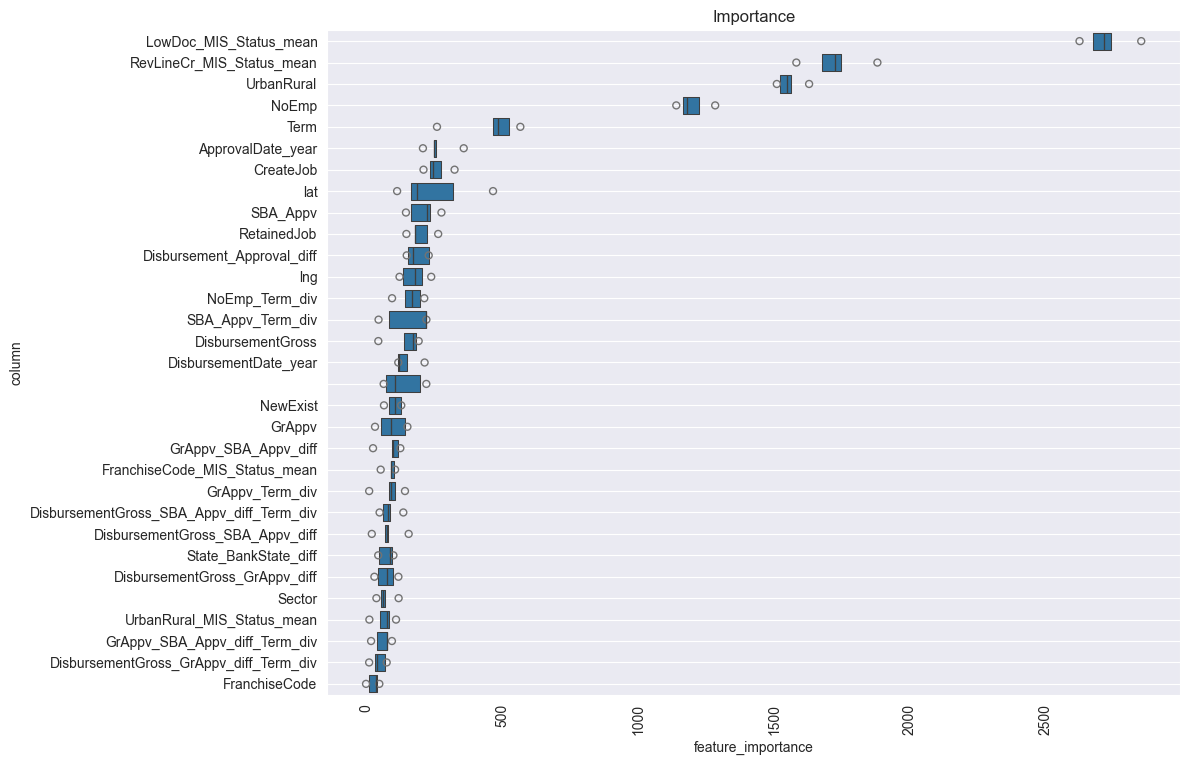

In [42]:
fig, ax = training.visualize_importance(models, train)

# Predict

In [43]:
threshold = 0.8

In [44]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [45]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6678410032930573


## Check result

### oofとtestの予測値分布を比較してバグを確認

<Axes: ylabel='Count'>

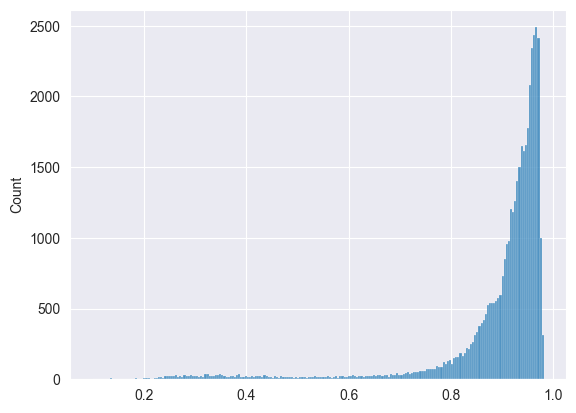

In [46]:
sns.histplot(oof)

<Axes: ylabel='Count'>

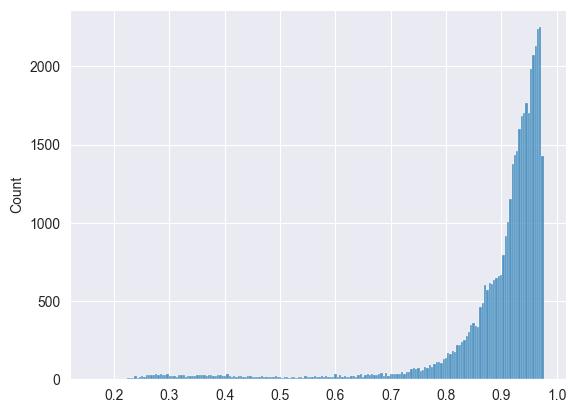

In [47]:
sns.histplot(pred_prob)

### 予測値の1の割合を確認

In [48]:
print(pred_class.sum() / len(pred_class))

0.9043206958494847


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.39
True Positive Rate (1の正解率): 0.94


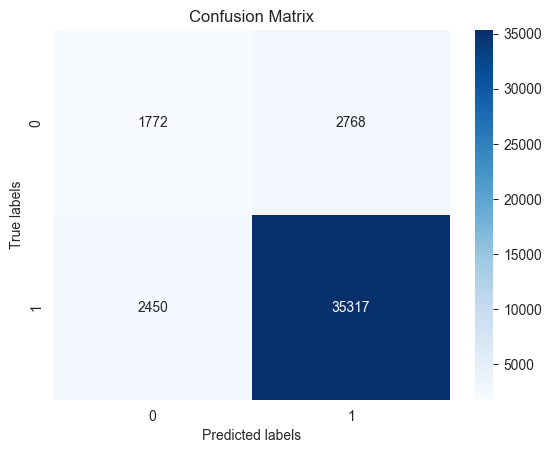

In [49]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [51]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)